<a href="https://colab.research.google.com/github/isil-y/EEGSleepModel/blob/main/Time_Series_Isil_Week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series data preprocessing

## Steps to consider



*   Data import
*   Data visualization
*   Resampling, splitting
*   Treating missing values: Imputation
*   Denoising
  - Rolling mean
  - Fourier transform
*   Standartization

The paper with datasets:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0256111#pone.0256111.ref042

In [ ]:
!wget https://zenodo.org/record/2650142/files/DatabaseSubjects.rar

--2023-04-27 13:28:30--  https://zenodo.org/record/2650142/files/DatabaseSubjects.rar
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1095949755 (1.0G) [application/octet-stream]
Saving to: ‘DatabaseSubjects.rar’

DatabaseSubjects.ra 100%[===================>]   1.02G  2.35MB/s    in 10m 31s 

2023-04-27 13:39:03 (1.66 MB/s) - ‘DatabaseSubjects.rar’ saved [1095949755/1095949755]



In [ ]:
!sudo apt install unar
!unar DatabaseSubjects.rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  gnustep-base-common gnustep-base-runtime gnustep-common libgnustep-base1.26
The following NEW packages will be installed:
  gnustep-base-common gnustep-base-runtime gnustep-common libgnustep-base1.26
  unar
0 upgraded, 5 newly installed, 0 to remove and 24 not upgraded.
Need to get 2,947 kB of archives.
After this operation, 14.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-common amd64 2.7.0-4 [39.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-base-common all 1.26.0-7 [70.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libgnustep-base1.26 amd64 1.26.0-7 [1,331 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-base-runtime amd64 1.26.0-7 [208 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/universe amd64 un

In [ ]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.3 MB/s eta 0:00:00


In [ ]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.fft import rfft, rfftfreq, irfft
from tqdm import tqdm

In [ ]:
def lowband_pass(data, data_freq, cutoff_freq):
    n = len(data)
    yf = rfft(data)
    xf = rfftfreq(n, 1/data_freq)
    yf[xf > cutoff_freq] = 0
    return irfft(yf)

def highband_pass(data, data_freq, cutoff_freq):
    n = len(data)
    yf = rfft(data)
    xf = rfftfreq(n, 1/data_freq)
    yf[xf < cutoff_freq] = 0
    return irfft(yf)

def preprocess_subject_data(patient_number: int):
    subject_filepath = "DatabaseSubjects/subject{}.edf".format(patient_number)
    data = mne.io.read_raw_edf(subject_filepath, verbose=False)
    raw_data = data.get_data()
    info = data.info
    channels = data.ch_names

    # selected_channels = ['EOG1', 'EMG1', 'CZ2-A1', 'O2-A1']
    selected_channels = ['ECG', 'EMG1', 'CZ2-A1', 'O2-A1']

    # print(channels)

    df = pd.DataFrame(raw_data.T, columns=channels)
    df = df[selected_channels]

    labels = []
    with open('/content/DatabaseSubjects/HypnogramAASM_subject{}.txt'.format(patient_number), 'r') as f:
        for line in f:
            labels.append(line.strip())
    labels = labels[1:]
    labels = labels[::6]
    
    # Resampling to 100 Hz
    df = df[::2]

    df['O2-A1'] = lowband_pass(df['O2-A1'].to_numpy(), 100, 49)
    df['CZ2-A1'] = lowband_pass(df['CZ2-A1'].to_numpy(), 100, 49)

    # Add highband for EMG
    df['EMG1'] = highband_pass(df['EMG1'].to_numpy(), 100, 10)

    scaled_features = StandardScaler().fit_transform(df.values)
    df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)[:(len(df) - len(df) % 3000)]

    data_final = df.values
    data_final = np.reshape(data_final, (-1, 3000, 4))

    labels = np.asarray(labels[:data_final.shape[0]], dtype=int)

    return data_final, labels

In [ ]:
X, y = preprocess_subject_data(1)
print('Subject 1 data shape: ', X.shape, y.shape)
for i in range(2, 21):
    X_subject, y_subject = preprocess_subject_data(i)
    print('Subject {} data shape: '.format(i), X.shape, y.shape)
    X = np.concatenate((X, X_subject), axis=0)
    y = np.concatenate((y, y_subject), axis=0)
    print('Intermidiate data shape stacked for {} subjects: '.format(i), X.shape, y.shape)

print('Total data shape: ', X.shape, y.shape)

Subject 1 data shape:  (961, 3000, 4) (961,)
Subject 2 data shape:  (961, 3000, 4) (961,)
Intermidiate data shape stacked for 2 subjects:  (1946, 3000, 4) (1946,)
Subject 3 data shape:  (1946, 3000, 4) (1946,)
Intermidiate data shape stacked for 3 subjects:  (2954, 3000, 4) (2954,)
Subject 4 data shape:  (2954, 3000, 4) (2954,)
Intermidiate data shape stacked for 4 subjects:  (4007, 3000, 4) (4007,)
Subject 5 data shape:  (4007, 3000, 4) (4007,)
Intermidiate data shape stacked for 5 subjects:  (5050, 3000, 4) (5050,)
Subject 6 data shape:  (5050, 3000, 4) (5050,)
Intermidiate data shape stacked for 6 subjects:  (6047, 3000, 4) (6047,)
Subject 7 data shape:  (6047, 3000, 4) (6047,)
Intermidiate data shape stacked for 7 subjects:  (7059, 3000, 4) (7059,)
Subject 8 data shape:  (7059, 3000, 4) (7059,)
Intermidiate data shape stacked for 8 subjects:  (8029, 3000, 4) (8029,)
Subject 9 data shape:  (8029, 3000, 4) (8029,)
Intermidiate data shape stacked for 9 subjects:  (9146, 3000, 4) (9146

In [ ]:
# Split data into train/test

In [ ]:
# Remove class -1
args = np.argwhere(y > 0)
y = y[args]
X = X[args]

In [ ]:
# Making labels to start from 0: transforming 1-5 range to 0-4 range
y -=1
print(np.unique(y))

[0 1 2 3 4]


In [ ]:
print(y.shape, X.shape)

(20242, 1) (20242, 1, 3000, 4)


In [ ]:
import tensorflow as tf

class MyModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.gru1 = tf.keras.layers.GRU(32, return_sequences=True)
    self.gru2 = tf.keras.layers.GRU(64, return_sequences=True)
    self.gru3 = tf.keras.layers.GRU(32, return_sequences=False)
    self.dense2 = tf.keras.layers.Dense(5, activation='softmax')
  
  def call(self, inputs, training=False):
    x = self.gru1(inputs)
    x = self.gru2(x)
    x = self.gru3(x)
    return self.dense2(x)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')

model = MyModel()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.build(input_shape=(None, 3000, 4))
print(model.summary())
model.fit(X.squeeze(), y, batch_size=64, epochs=100, validation_split=0.2, callbacks=[earlyStopping, reduce_lr_loss])
model.save('model.h5')

#Try to beat the val score of 0.67

Model: "my_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_21 (GRU)                multiple                  3648      
                                                                 
 gru_22 (GRU)                multiple                  18816     
                                                                 
 gru_23 (GRU)                multiple                  9408      
                                                                 
 dense_7 (Dense)             multiple                  165       
                                                                 
Total params: 32,037
Trainable params: 32,037
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
254/254 [==============================] - 69s 248ms/step - loss: 1.4240 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.3515 - val_sparse_categorical_accuracy: 0.

KeyboardInterrupt: ignored

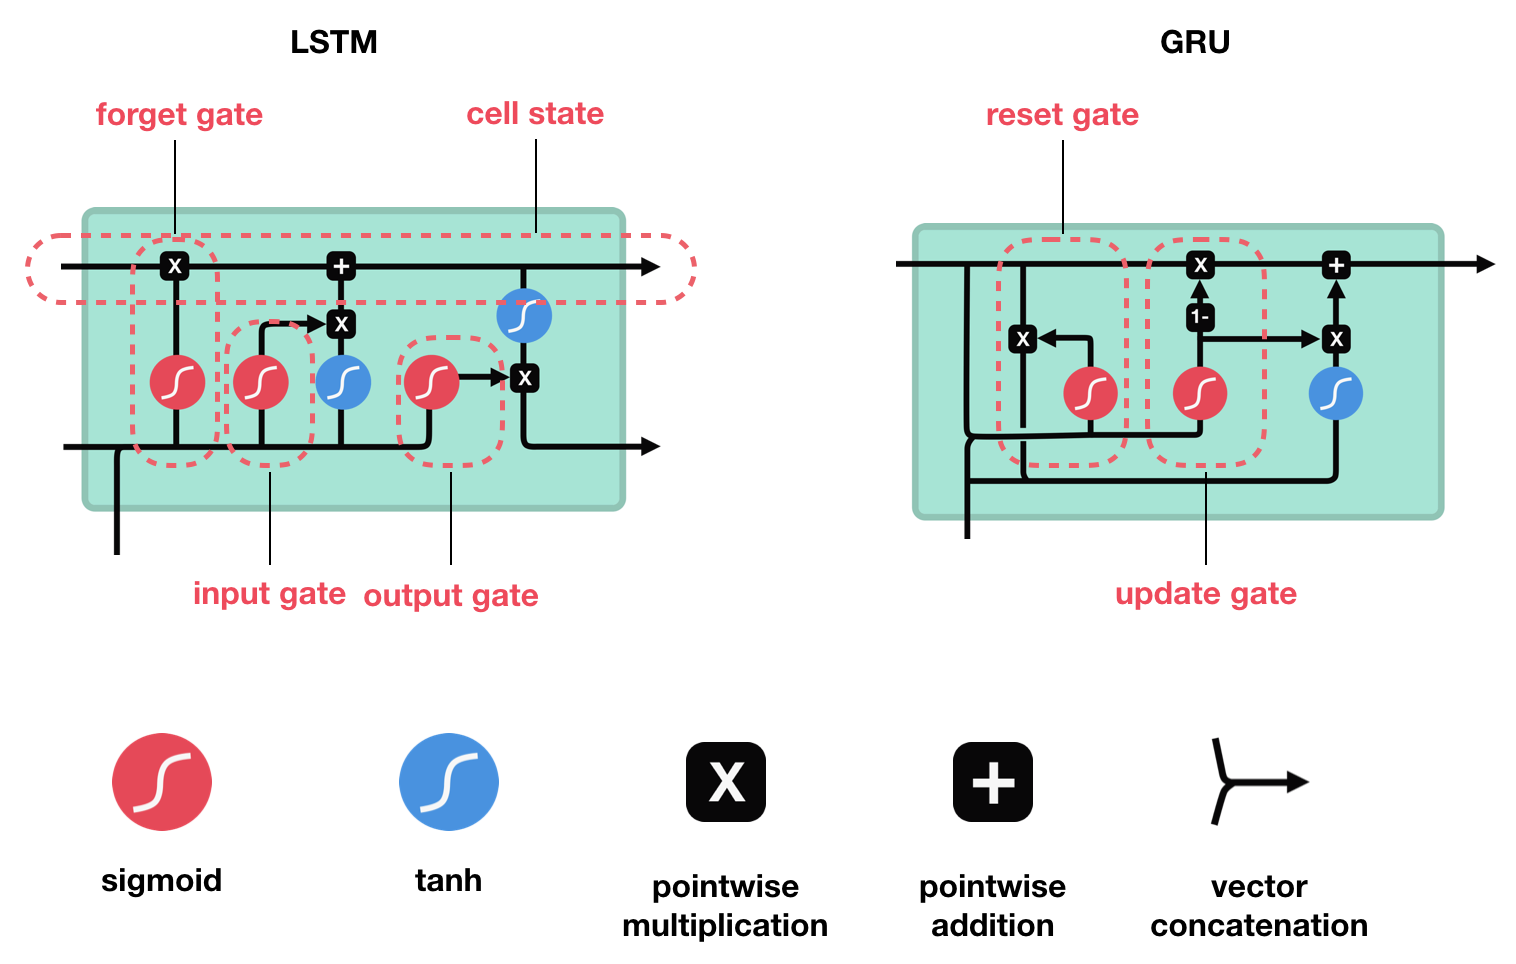